In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf
from DrawinGAN import Generator, Discriminator
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["figure.figsize"] = (8, 8)

%matplotlib inline

In [2]:
generator = Generator.DrawingGenerator(Generator.ConvBlock, output_channels=1).cuda(1)
discriminator = Discriminator.DrawingDiscriminator(input_channels=1).cuda(1)

In [30]:
model_root = r"D:\MLModels\SimpleStyleGAN\Good"

models_dict = {
    "discriminator": torch.load(model_root + "\\1561070753-discriminator.pth"),
    "generator": torch.load(model_root + "\\1561070753-generator.pth")
}

generator.load_state_dict(models_dict["generator"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

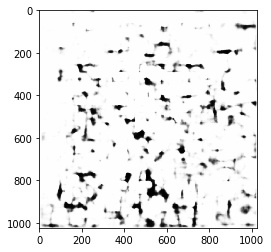

In [103]:
to_image = transforms.ToPILImage()

z = torch.randn(1, 512, 1, 1).cuda(1)

shift = torch.rand_like(generator.constant) + generator.constant

generator.constant.data = shift
fake = generator.forward(z, None)

grid = vutils.make_grid(fake.clone().cpu(), nrow=1, normalize=True)

im = to_image(grid)

plt.imshow(im)


In [24]:
z

tensor([[[[ 1.8395e+00]],

         [[ 5.0445e-01]],

         [[-7.9476e-01]],

         [[ 3.5819e-01]],

         [[-1.4927e+00]],

         [[ 1.2389e+00]],

         [[-4.9233e-01]],

         [[ 3.2920e-01]],

         [[ 1.6958e-01]],

         [[ 1.1060e+00]],

         [[-7.7375e-01]],

         [[-4.4337e-01]],

         [[ 8.8589e-02]],

         [[ 5.0424e-02]],

         [[-2.2228e+00]],

         [[-2.0114e+00]],

         [[-1.3429e+00]],

         [[ 6.6560e-01]],

         [[ 1.9734e-01]],

         [[-6.3591e-01]],

         [[-8.8253e-01]],

         [[ 2.0400e-01]],

         [[ 1.5756e+00]],

         [[ 2.6269e-03]],

         [[-1.7511e-01]],

         [[-1.9449e-01]],

         [[ 7.7323e-02]],

         [[ 1.4805e-01]],

         [[-1.7064e+00]],

         [[ 6.7454e-01]],

         [[-5.4023e-01]],

         [[ 9.4943e-01]],

         [[ 3.8116e-01]],

         [[ 4.3074e-01]],

         [[ 4.1151e-01]],

         [[-9.1104e-02]],

         [[ 4.9397e-01]],

 

In [6]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, sigma):
        mu_sq = mu.pow(2)
        si_sq = sigma.pow(2)

        kl_loss = (mu_sq + si_sq) - (sigma.pow(2).log() - 1)

        return kl_loss.sum().mul(0.5)

In [253]:
def kl_normal_loss(mu, var):
    return (0.5 * torch.sum(torch.exp(var) + mu ** 2 - 1. - var, dim=(1))).sum(dim=(0)).squeeze()

In [7]:
kld = KLDivergenceLoss()

tensor(0.)
tensor(0.)
tensor(27.6310)


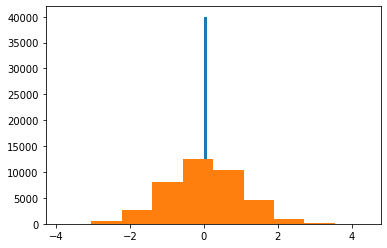

In [268]:
kld = nn.KLDivLoss(reduction="batchmean")

z = (torch.randn(4, 10000) * 0) + 0
n = torch.randn(*z.shape)

plt.hist(z.reshape(40000))
plt.hist(n.reshape(40000))

# kld(torch.sigmoid(z).log(), n)
z = z.reshape(4, 10000, 1, 1)
print(kl_normal_loss(z.mean(dim=(1)), z.std(dim=(1))))
print(nnf.binary_cross_entropy(z.mean(dim=(1)), torch.zeros_like(z.mean(dim=(1)))))
print(nnf.binary_cross_entropy(z.std(dim=(1)), torch.ones_like(z.std(dim=(1)))))

In [236]:
z_var = 0.005 * torch.randn(100) + 8
z_mu = 0.005 * torch.randn(100)

In [237]:
def sample_z(mu, log_var):
    eps = torch.randn(1, 100)
    return mu + torch.exp(log_var / 2) * eps

In [238]:
sample_z(z_mu, z_var)

tensor([[  44.4411,   21.5780,   81.8526,  -12.9856,   56.0774,  -90.3786,
          -48.6138,   40.3292,  -97.6494,   29.6642,   24.3893,   56.4579,
           19.9527,  -16.2126,   59.7541, -140.3399,   72.5085,   46.3855,
         -128.9914,   64.9641,   -9.9331,  -48.3493,   19.5867,  -77.2714,
          -33.5779,  -39.8739, -118.8971,   38.9667,   37.5785,   41.7167,
          -50.4552,   -3.9412,   61.8267,   -3.5703,  -15.6628,   47.8000,
          -58.3807,   26.7326,   63.7007,  -55.2798,   47.2320,  -84.5222,
          -28.0994,   38.7553,   73.0933,  -25.2377,  -84.6666,  -47.6233,
           25.3130,   23.8907,   11.2518,  -25.1249,   -2.1199,   32.0137,
           92.9952, -105.0394,   15.0874,  125.7669,   38.0028,   -1.9318,
            2.2513,  -19.3247,   79.4900,  -91.3007,  -27.9506,   80.4698,
          -53.4553,   44.2704,  -33.6860,   23.6024,   37.5542,   46.3855,
           66.5158,  -46.4234,   -4.3860,  -86.5263,  -15.4594,   -6.4910,
           14.7034,  -46.

In [206]:
kl_normal_loss(torch.zeros(2, 100, 1, 1), torch.ones(2, 100, 1, 1))

tensor(35.9141)

In [245]:
z_mu + torch.randn_like(z_mu) + z_var

tensor([ 9.6668,  8.1155,  7.6140,  8.7341,  8.5316,  7.3751,  8.6101,  7.9441,
         8.1842,  8.2888,  7.3828,  8.9123,  7.5380,  8.9503,  8.6544,  9.0716,
         8.4681,  5.7135,  8.3360,  6.1225,  7.7658,  8.3288,  6.2721,  7.8917,
         9.1923,  7.0380,  6.8773,  7.4276, 10.4058,  5.2342,  7.5003,  7.2157,
         9.7211,  7.3384,  6.6183,  9.8266,  6.5379,  7.8630,  6.4740,  9.8909,
         8.0221,  7.5065,  6.7382,  7.9371,  7.6916,  9.3507,  8.4358,  9.0676,
         6.5892,  7.3418,  7.2817,  7.7887,  9.6206,  7.2637,  8.3429,  8.9019,
         6.9266,  7.0435,  6.5492,  8.4050,  7.2516,  7.7004,  8.7408,  7.8298,
         8.5145,  7.6495,  8.5646,  9.8043,  6.7754,  7.4832,  8.7991,  8.2185,
         7.3118,  9.0140,  6.1507,  8.0502,  8.6178,  7.8885,  7.4361,  9.3973,
         9.6460,  7.7569, 10.8063,  6.0841,  7.5730,  8.1300,  7.8152,  5.7768,
         8.5054,  8.3322,  7.1735,  9.0183,  7.1799,  7.6674,  7.9915,  7.1806,
         7.9643,  8.4832,  8.4864,  7.59

In [246]:
z_mu + torch.exp(z_var / 2) * torch.randn_like(z_mu)

tensor([-2.2163e-01, -1.4860e+01, -3.9671e+01,  2.7144e+01,  1.9853e+01,
         1.0604e+02, -2.3435e+01, -4.4546e+01,  1.0190e+02, -2.3125e+01,
        -3.9524e+01, -3.9886e+00, -1.4473e+01,  6.0260e+01, -7.4855e+01,
         8.8968e+01, -2.0595e+01, -4.0035e+01,  1.2532e+02, -4.8993e+01,
        -4.6100e+01, -4.8906e+01, -9.8945e+01, -3.3715e+01, -3.6555e+00,
         5.5514e+01, -8.2654e+01, -4.0566e+01, -4.0502e+00,  2.3186e-01,
         1.0510e+01,  2.3429e+00, -7.2104e-01,  3.2825e+01, -1.8380e+01,
        -4.8892e+01, -8.5362e+01, -5.5773e+01,  8.7439e+01, -3.1452e+01,
         2.9995e+01,  4.0633e+00,  1.7043e+01, -4.3515e+01, -9.4715e+01,
         1.4850e+01,  4.3579e+01,  2.3341e+01,  7.0165e+01, -1.6717e+01,
        -2.2483e+01, -2.8095e+01,  8.3690e+01,  1.8453e+01, -3.5939e+01,
        -1.1825e+02, -2.5749e+00,  1.0357e+02, -3.8437e+00, -7.2590e+00,
        -5.3451e+01,  7.0156e+00, -2.3368e+01, -3.3239e+01, -1.0183e+02,
         3.7692e+01, -5.5691e+01, -7.5455e+01,  2.1

In [263]:
import functools
import operator

In [264]:
param = torch.randn(3, 4, 5)

functools.reduce(operator.mul, list(param.shape), 1)

60

In [269]:
torch.randn(1, 512, 1, 1)

tensor([[[[ 1.5908e+00]],

         [[-6.5252e-01]],

         [[ 1.7256e+00]],

         [[-6.0864e-01]],

         [[ 2.4896e-01]],

         [[-7.3929e-01]],

         [[-2.3175e-01]],

         [[-1.6765e-01]],

         [[-9.8636e-02]],

         [[ 4.6606e-01]],

         [[ 1.7229e+00]],

         [[ 1.0840e-01]],

         [[ 1.4540e+00]],

         [[-6.2815e-01]],

         [[ 9.5284e-01]],

         [[-9.0293e-02]],

         [[ 4.0523e-01]],

         [[-4.5808e-01]],

         [[-6.6079e-02]],

         [[-1.9438e+00]],

         [[ 7.4341e-01]],

         [[ 4.3479e-01]],

         [[ 2.8623e-01]],

         [[ 3.9523e-01]],

         [[ 2.4656e+00]],

         [[-1.8016e+00]],

         [[-8.1656e-02]],

         [[-1.1364e+00]],

         [[ 2.0375e+00]],

         [[ 1.8716e+00]],

         [[-1.8654e-01]],

         [[ 5.0033e-01]],

         [[-1.7435e+00]],

         [[ 8.6754e-01]],

         [[-1.3654e-01]],

         [[ 1.0244e+00]],

         [[-3.6626e-01]],

 

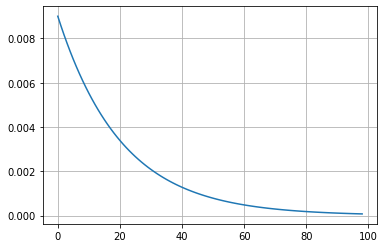

In [326]:
lr = 9e-3
lrs = []
for i in range(1, 100):
    lrs += [lr]
    lr = lr / 1.05
    
    
plt.plot(lrs)
plt.grid()
# plt.yscale('log')

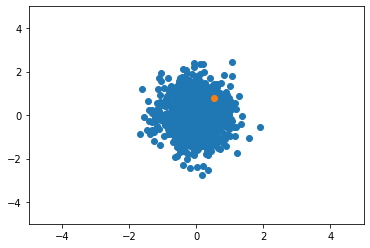

In [323]:

bx, by = torch.randn(2)

xs = []
ys = []

for i in range(1000):
    xs += [bx.item() * torch.randn(1).item()]
    ys += [by.item() * torch.randn(1).item()]

plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.scatter(xs, ys)
plt.scatter(bx, by)